# 采用遗传算法解决10城市TSP问题
10城市坐标为：
- 1： (41, 94)；
- 2： (37, 84)；
- 3： (54, 67)；
- 4： (25, 62)；
- 5： (7, 64)；
- 6： (2, 99)；
- 7： (68, 58)；
- 8： (71, 44)；
- 9： (54, 62)；
- 10： (83, 69)

## 思考：

- 遗传算法求解问题的性能与哪些因素有关？
- 遗传算法的缺陷有哪些？
- 有何改进措施？


In [1]:
import numpy as np
import  random
import matplotlib.pyplot as plt
%matplotlib inline

# 1. 获取临接矩阵

In [2]:
def CacDistance(a,b):
    """
    计算两点之间的距离
    """
    a = np.array(a)
    b = np.array(b)
    c = a-b
    distance = np.sqrt(np.sum(c*c))
    return distance

def CityDistance():
    """
    获取临接矩阵
    """
    locs = [(41, 94),(37, 84),(54, 67),(25, 62),(7, 64),(2, 99),(68, 58),(71, 44),(54, 62),(83, 69)]
    n = len(locs)

    dis_mat = np.zeros([10,10])
    for i in range(n-1):
        for j in range(i+1,n):
            dist = CacDistance(locs[i],locs[j])
            dis_mat[i,j] = dist

    for i in range(n):
        dis_mat[:,i] = dis_mat[i,:]

    return dis_mat

# 2. 遗传算法

## 2.1交叉

In [3]:
def Cross(p1,p2):
    a = np.array(p1).copy()
    b = np.array(p2).copy()

    # 0~9之间随机生成两个整数,作为映射的起始点和结束点
    begin = random.randint(0,9)
    end = random.randint(0,9)
    # 使 begin 小于 end
    if begin > end:
        temp = begin
        begin = end
        end = temp

    #print begin,end
    # 建立映射关系
    cross_map = {}
    is_exist = False
    # 初步映射
    for i in range(begin,end+1):
        if a[i] not in cross_map.keys():
            cross_map[a[i]] = []
        if b[i] not in cross_map.keys():
            cross_map[b[i]] = []

        cross_map[a[i]].append(b[i])
        cross_map[b[i]].append(a[i])


    # 处理传递映射 如1:[6],6:[3,1]-->1:[6,3,1],6:[3,1]
    # 计算子串中元素出现的个数，个数为2，则该元素为传递的中间结点，如如1:[6],6:[3,1],‘6’出现的次数为2
    appear_times = {}
    for i in range(begin,end+1):
        if a[i] not in appear_times.keys():
            appear_times[a[i]] = 0
        if b[i] not in appear_times.keys():
            appear_times[b[i]] = 0

        appear_times[a[i]] += 1
        appear_times[b[i]] += 1

        if a[i] == b[i]:
            appear_times[a[i]] -= 1


    for k,v in appear_times.items():
        if v == 2:
            values = cross_map[k]
            for key in values:
                cross_map[key].extend(values)
                cross_map[key].append(k)
                cross_map[key].remove(key)
                cross_map[key] = list(set(cross_map[key]))


    # 使用映射关系交叉
    # 先映射选中的子串
    temp = a[begin:end+1].copy()
    a[begin:end+1] = b[begin:end+1]
    b[begin:end+1] = temp

    # 根据映射规则映射剩下的子串
    seg_a = a[begin:end+1]
    seg_b = b[begin:end+1]

    remain = range(begin)
    remain.extend(range(end+1,len(a)))

    for i in remain:
        keys = cross_map.keys()
        if a[i] in keys:
            for fi in cross_map[a[i]]:
                if fi not in seg_a:
                    a[i] = fi
                    break

        if b[i] in keys:
            for fi in cross_map[b[i]]:
                if fi not in seg_b:
                    b[i] = fi
                    break

    return a,b            

## 2.2 变异

In [4]:
def Variation(s):
    c = range(10)
    index1,index2 = random.sample(c,2)
    temp = s[index1]
    s[index1] = s[index2]
    s[index2] = temp
    return s

## 2.3 计算适应度

In [5]:
def cost(s):
    dis = CityDistance()
    n = len(s)
    cost = 0
    for i in range(n):
        cost += dis[s[i],s[(i+1)%n]]
    return -cost

## 2.4 构建遗传算法

In [6]:
# 获取列表的第三个元素
def TakeThird(elem):
    """
    按适应度从大到小，排序时作为sort的key参数
    """
    return elem[2]

def CacAdap(population):
    """
    # adap n*4,n为行数，每行包括：个体下标,适应度,选择概率,累积概率
    """
    # 计算每一个个体的适应度,选择概率
    adap = []
    psum = 0
    # 计算适应度
    i = 0
    for p in population:
        icost = np.exp(cost(p))
        psum += icost
        # 添加个体下标
        adap.append([i])
        # 添加适应度
        adap[i].append(icost)
        i += 1
    # 计算选择概率
    for p in adap:
        # 添加选择概率和累积概率，这里累积概率暂时等于选择概率，后面会重新计算赋值
        p.append(p[1]/psum)
        p.append(p[2])

    # 根据适应度从大到小排序
    adap.sort(key=TakeThird,reverse=True)
    #print adap
    # 计算累计概率
    n = len(adap)
    for i in range(1,n):
        p = adap[i][3] + adap[i-1][3]
        adap[i][3] = p
    
    return adap

def Chose(adap):
    """
    轮盘选择操作
    """
    chose = []
    # 选择次数
    epochs = 20 #max(len(adap)/2,20)
    #while(len(set(chose)) <2):
    #print 'chosing...length %d'%len(set(chose))
    n = len(adap)
    for a in range(epochs):
        p = random.random()
        if adap[0][3] >= p:
            chose.append(adap[0][0])
        else:
            for i in range(1,n):
                if adap[i][3] >= p and adap[i-1][3] < p:
                    chose.append(adap[i][0])
                    break

    chose = list((chose))
    return chose

def Cross_Variation(chose,population):
    """
    交叉变异操作
    """
    # 交叉率
    p_c = 0.7
    # 变异率
    p_m = 0.3
    # 交叉变异操作
    chose_num = len(chose)
    sample_times = chose_num/2
    for i in range(sample_times):
        index1,index2 = random.sample(chose,2)
        #print index1,index2
        # 参与交叉的父结点
        parent1 = population[index1]
        parent2 = population[index2]
        # 这两个父结点已经交叉，后面就不要参与了，就像这两个人以及结婚，按规矩不能在与其他人结婚了，故从采样样本中移除
        chose.remove(index1)
        chose.remove(index2)
        
        p = random.random()
        if p_c >= p:
            child1,child2 = Cross(parent1,parent2)
            #print child1,child2
            p1 = random.random()
            p2 = random.random()
            if p_m > p1:
                child1 = Variation(child1)
            if p_m > p2:
                child2 = Variation(child2)
            population.append(list(child1))
            population.append(list(child2))
    return population

In [7]:
def GA(population):
    """
    一次遗传过程
    """
    
    adap = CacAdap(population)

    # 选择操作
    chose = Chose(adap)
    # 交叉变异
    population = Cross_Variation(chose,population)
        

    return population

## 2.5 循环调用遗传算法，直到达到终止条件

In [8]:
def find_min(population):
    loss = []
    # 遗传次数
    epochs = 51
    i = 0
    while i < epochs:
        adap = []
        # 计算适应度
        for p in population:
            icost = cost(p)
            adap.append(icost)
        
        # 使用遗传算法更新种群
        population = GA(population)
        
        min_cost = max(adap)
        if i%10 == 0:
            print 'epoch %d: loss=%.2f'%(i,-min_cost)
        loss.append([i,-min_cost])
        i += 1
        if i == epochs:
            # 输出最优解
            p_len = len(population)
            for index in range(p_len):
                if adap[index] == min_cost:
                    print '最优路径:'
                    print population[index]
                    print '代价大小:'
                    print -min_cost
                    break
    # 打印损失函数变换
    loss = np.array(loss)
    plt.plot(loss[:,0],loss[:,1])
    plt.title('GA')
    

epoch 0: loss=313.19
epoch 10: loss=243.34
epoch 20: loss=242.28
epoch 30: loss=242.28
epoch 40: loss=242.28
epoch 50: loss=242.28
最优路径:
[1, 0, 5, 4, 3, 8, 6, 7, 9, 2]
代价大小:
242.2750498099476


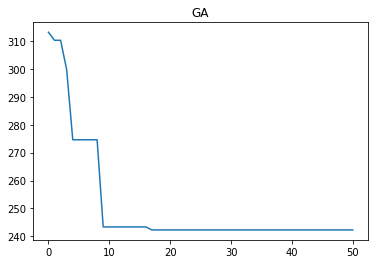

In [9]:
# 初始化
s1 = [1,2,3,4,5,6,7,8,9,0]
s2 = [5,4,6,9,2,1,7,8,3,0]
s3 = [0,1,2,3,7,8,9,4,5,6]
s4 = [1,2,3,4,5,7,6,8,9,0]
population = [s1,s2,s3,s4]
# 调用
find_min(population)